In [1]:
#imports
import random as rd
import numpy as np
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [2]:
def sample(prob): # BS can be done
    r = rd.random();i = 0
    while r > prob[i]:
        r-=prob[i]
        i+=1
    return i

def bernoulli(prob):
    if rd.random() > prob:
        return 1.0
    return 0.0

def row_normalize(arr):
    arr = np.array(arr,float)
    for i in range(np.shape(arr)[0]):
        arr[i] = arr[i]/np.sum(arr[i])
    return arr

def steady_state_prob(matrix):
    """
    This function calculates relative throughput from a probability matrix
    :param matrix: the probability matrix
    :return: A list of relative throughput values
    """
    a_list = []
    b_list = []
    for v in matrix:
        a_list.append(1)
        b_list.append(0)
    b_list.append(1)
    A = np.append(np.transpose(matrix) - np.identity(len(matrix)), [a_list], axis=0)
    b = np.transpose(np.array(b_list))
    return np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))


def dot(x,y):
    return np.sum(np.multiply(x,y))

In [ ]:
# parameters custom
en = 3
ch = 3
P = np.array([[.1, .2, .7],[.5, .3, .2],[.3, .3, .4]])
E = np.array([[.5,.6,.4],[.2,.3,.1],[.4,.5,.3]])
R = np.array([8.,6.,4.])
tol = .3
print(P)
print(E)
print(R)

In [14]:
en = 5
ch = 4
P = np.array([[.35,.15,.05,.45],[.3,.3,.2,.2],[.3,.4,.1,.2],[.2,.15,.25,.4]])
E = np.array([[.4,.6,.4,.3],[.3,.4,.4,.3],[.3,.2,.1,.4],[.1,.35,.3,.4],[.2,.4,.1,.3]])
R = np.array([7.,5.5,4.,6.,5.])
tol = .35
print(P)
print(E)
print(R)
print(tol)

[[0.35 0.15 0.05 0.45]
 [0.3  0.3  0.2  0.2 ]
 [0.3  0.4  0.1  0.2 ]
 [0.2  0.15 0.25 0.4 ]]
[[0.4  0.6  0.4  0.3 ]
 [0.3  0.4  0.4  0.3 ]
 [0.3  0.2  0.1  0.4 ]
 [0.1  0.35 0.3  0.4 ]
 [0.2  0.4  0.1  0.3 ]]
[7.  5.5 4.  6.  5. ]
0.35


In [15]:
ub = np.sum(E*steady_state_prob(P),axis=1)
ltemp = linprog(c = -1*R, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='simplex')
print(np.dot(ltemp.x,R), np.sum(ltemp.x),ltemp.con, ltemp.success, np.dot(ltemp.x,ub))
print(ltemp.x)
org_lamda = ltemp.x

6.50100842330051 1.0 [0.] True 0.35
[0.50100842 0.         0.         0.49899158 0.        ]


In [16]:
lamda = [np.ones(en)/en]
p = []
# p.append(row_normalize(np.random.rand(ch,ch)))
p.append(row_normalize(np.ones((ch,ch))))
pckts = 1
chnl = []; b = [] ; enc = []
emp_rate = [0]; emp_err = [0]
chnl.append(rd.randint(0,ch-1))
enc.append(rd.randint(0,en-1))
b.append(np.zeros(pckts))
step = 10
t = 0
lr = 0.01
beta = 5

In [17]:
T = 20000
sprob = steady_state_prob(p[-1])
temp = np.copy(p[-1])
while t <= T:
    enc.append(sample(lamda[-1]))
    chnl.append(sample(P[chnl[-1]]))
    b.append(np.zeros(pckts))
    for i in range(pckts):
        b[t+1][i] = bernoulli(E[enc[-1]][chnl[-1]])
    tprob = np.zeros(ch)
    ones = np.sum(b[-1])
    for j in range(ch):
        tprob[j] = math.exp(beta*(((pckts-ones)*E[enc[-1]][j])+((ones)*(1-E[enc[-1]][j]))))
    tprob = row_normalize([tprob])[0]
    for i in range(ch):
        for j in range(ch):
            temp[i,j] = temp[i,j] + lr*((sprob[i]*tprob[j]) - temp[i,j])
    temp = row_normalize(temp)

    if t%step == 0:
        p.append(temp)
        sprob = steady_state_prob(p[-1])
        ub = np.sum(E*sprob,axis=1)
        ltemp = linprog(c = -1*R, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1e-2})
        sprob = np.exp(beta*sprob)
        sprob = row_normalize([sprob])[0]
        temp = np.copy(p[-1])
        lamda.append(ltemp.x)
        emp_err.append(np.dot(ltemp.x,ub))
        emp_rate.append(np.dot(ltemp.x,R))
        print(t,emp_rate[-1],ltemp.success)
    t+=1

0 6.454300765698465 True
10 6.456158194112269 True
20 6.4564884961892695 True
30 6.458231151994552 True
40 6.461172199049601 True
50 6.463547287385818 True
60 6.466247522901616 True
70 6.464912260619885 True
80 6.466903718557689 True
90 6.468404911522855 True
100 6.468144497676201 True
110 6.470594776939288 True
120 6.473824840455677 True
130 6.474213279650113 True
140 6.475179337266201 True
150 6.477149523000633 True
160 6.479233014680858 True
170 6.480004148907575 True
180 6.481160237901838 True
190 6.483782094046864 True
200 6.483106619737845 True
210 6.485847967732342 True
220 6.485105559286829 True
230 6.484388939587129 True
240 6.484310797030815 True
250 6.485015101766027 True
260 6.488353509778394 True
270 6.490602094662388 True
280 6.494737920581253 True
290 6.495070051751666 True
300 6.4926869300223125 True
310 6.493416718418026 True
320 6.495275037070746 True
330 6.498923098424186 True
340 6.501984427261293 True
350 6.502607763384782 True
360 6.5024658915812905 True
370 6.501

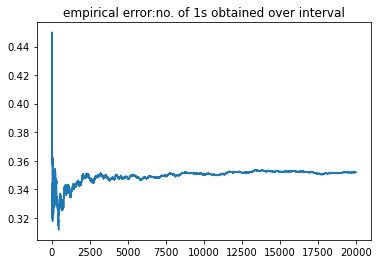

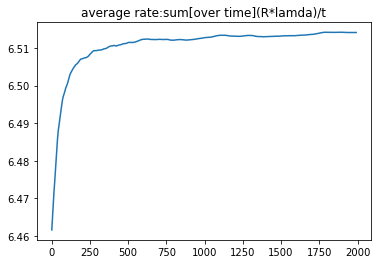

In [18]:
# new proper plots
stat = 10
error_plot = float(pckts) - np.sum(b,axis=1)
for i in range(1,len(error_plot)):
    error_plot[i] += (error_plot[i-1]*(i-1))
    error_plot[i] =error_plot[i]/i
plt.plot(error_plot[stat:])
plt.title('empirical error:no. of 1s obtained over interval')
plt.show()
rate_plot = np.copy(emp_rate)
for i in range(1,len(rate_plot)):
    rate_plot[i] += (rate_plot[i-1]*(i-1))
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[stat:])
plt.title('average rate:sum[over time](R*lamda)/t')
plt.show()

In [19]:
error_plot[-1], rate_plot[-1]

(0.3518324083795819, 6.514086984453039)

10.437050594844123


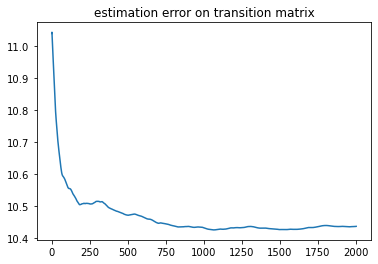

In [20]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in range(len(p)):
    err.append(np.sqrt(np.sum(np.square(P-p[i]))/s)*100)
    err[i] += (err[i-1]*(i))
    err[i] = err[i]/(i+1)
print(err[-1])
plt.plot(err)
plt.title('estimation error on transition matrix')
plt.show()

[0.3156515  0.23329065 0.2142488  0.23680906]
[0.28025478 0.22321946 0.15894615 0.33757962]
0.11478148757754819


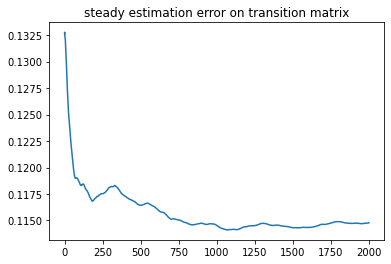

In [24]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in range(len(p)):
    err.append(np.sqrt(np.sum(np.square(steady_state_prob(P)-steady_state_prob(p[i])))))
    err[i] += (err[i-1]*(i))
    err[i] = err[i]/(i+1)
print(steady_state_prob(p[-1]))
print(steady_state_prob(P))
print(err[-1])
plt.plot(err)
plt.title('steady estimation error on transition matrix')
plt.show() 

1.1500980435100532


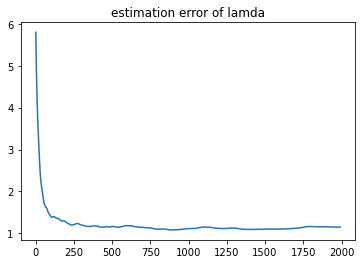

In [22]:
err = []; s = 3
for i in range(len(lamda)):
    err.append(np.sqrt(np.sum(np.square(org_lamda-lamda[i]))/s)*100)
    err[i] += (err[i-1]*(i))
    err[i] = err[i]/(i+1)
print(err[-1])
plt.plot(err[10:])
plt.title('estimation error of lamda')
plt.show()

In [ ]:
# old plots

In [ ]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in p:
    err.append(np.sqrt(np.sum(np.square(P-i))/s)*100)
plt.plot(err)
plt.title('estimation error')
plt.show()

In [ ]:
print(p[-1])
print(P)
print(lamda[-1])
print(sprob)

In [ ]:
error_plot = pckts - np.sum(b,axis=1)
for i in range(1,len(error_plot)):
    error_plot[i] += (error_plot[i-1]*(i-1))
    error_plot[i] =error_plot[i]/i
plt.plot(error_plot[1:])
plt.title('rolling error')
plt.show()
rate_plot = [0]
for i in range(1,len(b)):
    rate_plot.append((rate_plot[i-1]*(i-1))+rate[enc[i]])
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[2:])
plt.title('rolling rate')
plt.show()

In [ ]:
print(rate_plot[-1],error_plot[-1])

In [ ]:
ub = np.sum(E*steady_state_prob(P),axis=1)
ltemp = linprog(c = -1*rate, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='simplex')
print(steady_state_prob(P))
print(np.dot(ltemp.x,rate), np.sum(ltemp.x),ltemp.con, ltemp.success, np.dot(ltemp.x,ub))

In [ ]:
# plt.plot(emp_err[1:])
# plt.title('emperical error')
# plt.show()
plt.plot(emp_rate[1:])
plt.title('emperical rate')
plt.show()
print(emp_rate[-1])